$\textbf{State of Art}$

I Variational Quantum Computers sono un approccio computazionale attuale e applicabile a molti problemi. Tuttavia, al crescere della dimensione del circuito quantistico si incontrano problemi gravi, quali la concentrazione esponenziale della funzione di perdita attorno alle soluzioni, fenomeno spesso etichettato come Barren Plateau (BP).

Studi recenti hanno collegato la nascita del BP a circuiti in cui è presente rumore o circuiti unitari, tramite formalismi di Lie. Tuttavia, i risultati ottenuti non sono generalizzabili al caso in cui rumore e operazioni unitarie convivono.

Recentemente sono usciti nuovi studi, che hanno introdotto una notazione e teoria a matrici non negative per poter descrivere l'andamento del BP e dei VQA.
Il lavoro di questo JPYNB vuole introdurre i VQA e spiegare in maniera accessibile  studio 'Estimates of loss function concentration in noisy parametrized quantum circuits
 Giulio Crognaletti,1,2,3, ∗ Michele Grossi,3,† and Angelo Bassi1,2'. Inoltre, il notebook fornirà un esposizione dei risultati numerici ottenuti sulla falsa riga dello studio sopracitato e condivide il codice da cui implementare gli strumenti per calcolare le varianze di algoritmi VQA.


$\textbf{Circuiti quantistici parametrizzati (PQC) }$

I circuiti quantistici parametrizzati (PQC) sono utilizzati in algoritmi ibridi quantistici-classici per risolvere problemi computazionali. Sono fondamentali in applicazioni moderne come gli Algoritmi Quantistici Variazionali (VQA), poiché gestiscono meglio gli errori.

Le componenti principali dei VQA includono porte quantistiche parametrizzate e un ottimizzatore classico che regola i parametri per minimizzare o massimizzare una funzione obiettivo. Gli algoritmi VQA funzionano in modo iterativo, alternando elaborazione quantistica e classica, e la scelta dell'ansatz influisce sull'ottimizzazione.

Le funzioni di costo traducono i parametri quantistici in valori reali, mentre l'ottimizzatore cerca i minimi su una ipersuperficie definita da:

$$C(θ)=∑kfk(Tr(Okρk(θ)))$$


$\textbf{QML (Quantum Machine Learning)}$

Le reti neurali quantistiche (QNN) uniscono elementi classici e quantistici, caricando dati in uno stato quantistico e elaborandoli con porte parametrizzate. L'output viene misurato e utilizzato in una funzione di perdita per addestrare i pesi tramite backpropagation.


In [4]:
from IPython.display import Image, display

image5 = "/Users/sebastianopian/Documents/Uni/Magistrale/Qc/QC.exam/Img/Screenshot_23-1-2025_104642_.jpeg"

display(Image(filename=image5, width=600, height=400))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sebastianopian/Documents/Uni/Magistrale/Qc/QC.exam/Img/Screenshot_23-1-2025_104642_.jpeg'

### Barren Plateau

Il fenomeno del *barren plateau* si verifica nei circuiti quantistici parametrizzati (PQC) quando i gradienti della funzione costo tendono ad annullarsi esponenzialmente all'aumentare del numero di qubit. Questo rende difficile l'addestramento degli algoritmi quantistici variazionali, poiché la probabilità che il gradiente lungo una direzione significativa sia diverso da zero diminuisce rapidamente con l'aumentare dei qubit.


# Settings

Dato uno spazio di Hilbert di più qbit, su cui agiscono gate quantistici, è naturale dividerlo in $ \textit{H} = \otimes_{m} H_m $, con $ \text{dim}(\mathcal{H}) = \prod_{m} \text{dim}(\mathcal{H}_m) $. Con $ \mathcal{H}_m $ indichiamo un Q-bit o un gruppo di qbit e con $ \Phi_{\vec{\theta}} $ il canale quantistico (il circuito) che agisce sui Q-bit. La divisione viene fatta sulla nozione di località, che sarà approfondita più avanti.

La funzione di costo che viene minimizzata è $ \mathcal{L}_{\rho, k} = \text{Tr}[\Phi(\rho)H] $, con $ H $ osservabile da determinare. La sua utilità sta nel fatto che il BP può essere visto dalla varianza di $ \mathcal{L}: \textbf{V}_{\rho,H}(\theta) $. Nello specifico, c'è un BP se $ \textbf{V} \propto O(e^{-\beta n}) $ con $ n $ numero di QBIT. Questa funzione di costo ci permette di escludere molti casi in cui nasce BP.

In generale, lo spazio $ H $ può essere suddiviso in sottosistemi locali. Questa suddivisione di $ H $ induce una corrispondente partizione dello spazio $ B $ degli operatori su $ H $. Gli operatori in $ B $ vengono raggruppati in sottospazi $ B_\kappa $, ciascuno identificato da un vettore binario $ \kappa $ (con $ \kappa \in \{0, 1\}^M $), che indica su quali sottosistemi locali gli operatori agiscono trivialmente e su quali non (per ogni sottospazio non triviale $ \kappa_m = 1 $).

Lo spazio $ B $ è scomposto come somma diretta:
$$
B = \bigoplus_{\kappa \in \{0,1\}^M} B_\kappa.
$$
La dimensione di ciascun sottospazio $ B_\kappa $ è data da:
$ d_\kappa = \prod_m (d_m^2 - 1)^{\kappa_m} $, dove $ d_m $ rappresenta la dimensione del sottosistema $ H_m $. Il caso speciale $ \kappa = 0 $ corrisponde a operatori triviali.

In pratica, dato che gli operatori e gli spazi di Hilbert dei Qbit vivono nella stessa dimensione, possiamo dividere lo spazio di Hilbert in base a come gli operatori agiscono su di esso. Se, per esempio, un operatore $ A $ agisce trivialmente sul primo Qbit e non trivialmente sul secondo, lo indicheremo con la stringa (10).

Questa divisione ha a che vedere con la teoria dei grafi. Come vedremo più avanti, gli operatori faranno nascere dei sottospazi isolati nello spazio di Hilbert. Ovvero, uno stato che nasce in un sottospazio resterà in quel sottospazio anche dopo l'applicazione lineare.

Allo stesso tempo, osserveremo la nascita di sottospazi che si disperdono. Ovvero, le applicazioni faranno nascere dei sottospazi non isolati, che porteranno i propri elementi in sottospazi isolati. Ovvero, i sottospazi isolati assorbiranno informazione dai sottospazi dispersivi.

Questa osservazione relativa alla dispersione e all'assorbimento di stati, dunque di informazioni, è alla base di questo lavoro, in quanto l'assorbimento da una parte all'altra del circuito è una causa importante dell'aumento della varianza.


#Notazione

Un operatore $ A \in B $ si dice $ \kappa $-locale se appartiene a $ B_\kappa $. A ciascun operatore si associa un vettore di località $ \ell_A \in \mathbb{R}^{2^M} $, che descrive quanto l'operatore è distribuito nei vari sottospazi $ B_\kappa $. Il vettore di località $ \ell_A $ è definito come un vettore di dimensione pari al numero di sottospazi in cui lo spazio $ B $ è suddiviso. Ogni componente $ (\ell_A)_\kappa $ rappresenta la proiezione dell'operatore $ A $ sul sottospazio $ B_\kappa $. Questa formula misura la somma dei quadrati delle proiezioni dell'operatore $ A $ sugli elementi della base $ \{B_j\}_j $, normalizzata rispetto alla dimensione del sottospazio. Questo vettore è calcolato utilizzando una base ortonormale hermitiana $ \{B_j\}_j $ di $ B_\kappa $, e gli elementi di $ \ell_A $ sono definiti come:
$$
(\ell_A)_\kappa = \frac{\sum_{j=1}^{d_\kappa} \text{Tr}[B_j A]^2}{d_\kappa}.
$$

Se $ A $ è un operatore locale, il vettore di località assume la forma più semplice:  $ (\ell_A)_\lambda = \delta_{\kappa,\lambda} \|A\|_2 $.

A questo punto siamo interessati a capire quando un operatore lineare che agisce su $ B $ preserva la località dello spazio, cioè quanto due sottospazi di $ B $ sono messi in comunicazione da un operatore lineare. Questo è rappresentato dalla matrice di trasferimento di località $ T $, i cui elementi sono definiti come:
$$
T_{\kappa,\lambda} = \frac{1}{d_\kappa} \sum_{j=1}^{d_\kappa} (\ell_{\Lambda(B_j)})_\lambda,
$$
dove $ \ell_{\Lambda(B_j)} $ è il vettore di località associato all'immagine di $ B_j $ sotto $ \Lambda $.

La matrice $ T $ può essere organizzata in blocchi per evidenziare meglio le interazioni tra gruppi di sottospazi. Ad esempio, se i sottospazi $ B_\kappa $ sono raggruppati in modo gerarchico, la matrice $ T $ può essere scritta come:
$$
T =
\begin{bmatrix}
T^{(1,1)} & 0 & \cdots & T^{(1,n)} \\
0 & T^{(2,2)} & \cdots & T^{(2,n)} \\
\vdots    & \vdots    & \ddots & \vdots    \\
0 & 0 & \cdots & T^{(n,n)}
\end{bmatrix},
$$
dove i blocchi diagonali $ T^{(i,i)} $ rappresentano la preservazione della località all'interno di ciascun gruppo di sottospazi, mentre l'ultima colonna rappresenta la nascita del fenomeno di assorbimento.

#Varianza

$ L $ è il numero dei layers. $ E_{\theta}\{.\} $ rappresenta il valore di aspettazione rispetto al parametro $ \theta $. Vale: $ E_{\theta}(\text{Tr}[\mathcal{U}_{\theta}(\rho)H]^2) = (l_{\rho},l_H) $. Dunque, termini di località diversa non contribuiscono insieme alla varianza, ma si sommano semplicemente. In generale: $ E_{\theta}(\text{Tr}[\Phi_{\theta}(\rho)H]^2) = (l_{\rho}, \prod_{l=1}^{L}T_l l_H) $, dunque:

$$
\textbf{V}_{\rho,H}^L = (l_{\rho}, \prod_{l=1}^{L}T_l l_H) - \frac{\text{Tr}[H]^2}{d^2}.
$$

Questa formula è inutilizzabile per grandi profondità a causa della sua complessità computazionale; ciò nondimeno sarà usata per ricavare il limite a profondità grandi.



###CIRCUITI PROFONDI

Per circuiti profondi, il contributo degli autovalori $T_l$ diventa dominante.
Considereremo circuiti dove $\mathcal{E_l = E}$ e dove tutti gli osservabili H hanno traccia nulla, in modo che il secondo termine della varianza sia uguale a zero e che scompaia la sommatoria in favore di L.


$$\textbf{V}_{\rho,H}^L = (l_{\rho},\prod^L T_l l_H)$$

Dove $T_l$ è la matrice TLM del gate $𝛆_l †$

Se $L \rightarrow \infty $,

$$V_\infty^{\rho,H} = \sum_z (\ell \rho_z, w_z)(\ell_H)_z + (\ell \rho_z, w_z)(A \ell_H)_z$$
Dove $w_z$ è autovalore destro di $T_z$.
Semplificando ulteriormente il problema al caso in cui il canale epsilon è formato da rumore sui singoli qbit e da canali unitari, $\mathcal{E = N \cdot W}$, allora la varianza assume la forma al limite:

$$V_\infty^{\rho,H} = \sum_z \left( \frac{(\ell \rho)_z (\ell_H)_z}{d_z} + \frac{(\ell \rho)_z (A \ell_{H})_z}{d_z} \right).$$

Sotto le assunzioni fatte, vale:
$$\|\frac{1}{L}\sum_l V_{\rho,H}^L - V_{\rho,H}^{\inf}\| \simeq  e^{-{\beta L}} \|H\|^2 .$$

In generale, non è detto che la varianza converga ad un valore ma almeno rimane limitata. Nel lavoro, la convergenza della varianza sarà studiata dalla limitazione:

$$
\left| V^l_{\rho, H} - V^\infty_{\rho, H} \right| \in O\left(e^{-\beta L }\|H\|_2^2\right)
$$

Questo mette in evidenza come alcuni sottospazi si comportano da attrattori per la varianza. A è la matrice di assorbimento che quantifica il contributo di questi termini (non negativi).

Tanto più grande è il valore di A sullo spazio vettoriale, tanto più grande è il centramento tra i vari canali quantistici dunque tanto piu grandi sono i sottospazi essenziali.

###CIRCUITI PICCOLI

Non possiamo più in questo caso assumere che la convergenza sia raggiunta da subito e le approssimazioni fatte non valgono più. Dovremo limitarci a cercare un lower bound per $V^L$. Il trucco è studiare diverse situazioni in cui la varianza converge velocemente. La richiesta è che $\beta L \simeq log(n)$, ovvero che il circuito abbia pochi layer, in questo modo $V^{\infty}$ non è mai raggiunto. $\beta$ dipende dalle correlazioni non locali.
Questa condizione di lentezza è data dal seguente teorema:

Dati $\mathcal{E_{l}}, \mathcal{T_{l}}$ e posto $\alpha_l= min_{\mathcal{k} \in K}(T_l)_{\mathcal{k,k}}$. allora:

$$V_L^{\rho,H} \geq   \alpha^L (l_{\rho},l_{\mathcal{K(H)}})$$


Dove $\mathcal{K}$ è il proiettore su  $\mathcal{B}_K = \oplus_{\mathcal{k}\in K} \mathcal{B_k}$ e $\alpha$ è la media degli $\alpha_l$.

Inoltre, se: $  \alpha >0 \ e \ L \simeq logn \ \ \ o  \ \ \ \alpha= 1 - f(n,L) \ con \ f\simeq log(n)/L$, allora:

$$V_L^{\rho,H} \geq  f(n) (l_{\rho},l_{\mathcal{K(H)}})$$

dove $f \simeq 1/poly(n)$.

Questi risultati sono stati ottenuti per T circa I, simile alla condizione dei piccoli angoli.


###NOISE NON UNITALE


Adesso prendiamo in considerazione circuiti quantistici affetti da noise non unitale, come per esempio un rumore depolarizzante.
 Consideriamo $\mathcal{E}_c(\rho) = (1-p)\mathcal{E}(\rho) + p\tilde{\rho}$ dove  $\tilde{\rho}$ è uno stato arbitrario, E è un canale unitario che rappresenta l'entanglement, p l'errore. Possiamo pensare a $\Phi(\rho)= (1-p)\rho + p\tilde{\rho}$ e $\mathcal{E \circ U}$


$$V_{\inf}^{\rho,H} \geq   p^2(l_{\\tilde{\\rho}}(I-(1-p)^2T)l_H)$$

e se T è un proiettore,

$$V_{\inf}^{\rho,H} \geq (p/(2-p)-p^2)(l_{\tilde{\rho}}, Tl_H) + p^2(l_{\tilde{\rho}}, l_H)$$

Notiamo che è scomparsa la dipendenza dallo stato iniziale. Solo i layer dopo un certo l contribuiscono sensibilmente alla varianza.

In particolare, possiamo considerare due limiti contrapposti. Nel primo il noise entangla lentamente lo stato, a quel punto il primo termine è dominante. D'altra parte se il noise entangla velocemente lo stato è il secondo termine ad essre dominante.

#SCELTA DEL SDR PER RISULTATI NUMERICI


Per simulare il rumore entangling, sono stati usati gli operatori di Kraus. $\rho \rightarrow \Phi(\rho)= \sum_i K_i \rho K_i^+$ con $\sum_i K_i K_i^+ =I$. Se utilizziamo $K_0 = \sqrt{1-p}I, K_1=\sqrt{p}W$. Con probabilità p che venga applicato W, operatore che manda lo stato nel GHZ (stato di massimo entanglement):
$$\tilde{\rho} = \frac{(\vert 0 \rangle^{\otimes n} + \vert 1 \rangle^{\otimes n})(\langle 0 \vert^{\otimes n} + \langle 1 \vert^{\otimes n})}{2^n}$$.
Lo stato iniziale è fissato come $\rho = (\vert 0 \rangle \langle 0 \vert)^{\otimes n}$ a cui vengono applicate una serie di rotazioni su X e Z casuali.

Il canale considerato è della forma $E_c = N \circ E$, dove:
$$E_c(\rho) = (1-p)E(\rho) + p\tilde{\rho},$$

L'utilità è che lo stato GHZ può essere rappresentato da somme di matrici di Pauli rendendolo facilmente computabile.

La parte entangling è rappresentata in Fig. 4. Sebbene il numero di strati $L$ necessari per raggiungere la convergenza a $V^\infty_{\rho, H}$ sia logaritmico, la velocità di mescolamento dipende dalla parte entangling. Per questo motivo, $L = 8$ strati sono sufficienti nel caso di entanglement rapido, mentre $L = 20$ sono necessari per l'entanglement lento.

L'osservabile è fissato come:
$$
H = h \sum_{k=1}^n Z_k \otimes Z_{k+1},
$$
dove il fattore di normalizzazione $h$ è scelto come $h = 9/n$. Questo assicura che:
$$
(\ell_{\tilde{\rho}}, \ell_H) = 1,
$$
rendendo il confronto particolarmente semplice.

Lo stato $\tilde{\rho}$ può essere decomposto utilizzando la base di Pauli normalizzata $\{I, X, Y, Z\}^{\otimes n}$. In particolare, usando le seguenti espressioni:
$$
\vert 0 \rangle \langle 0 \vert = \frac{I + Z}{2}, \quad
\vert 1 \rangle \langle 1 \vert = \frac{I - Z}{2}, \quad
\vert 0 \rangle \langle 1 \vert = \frac{X + iY}{2}, \quad
\vert 1 \rangle \langle 0 \vert = \frac{X - iY}{2},
$$
possiamo scrivere $\tilde{\rho}$ come somma di termini che coinvolgono stringhe di Pauli.

Sfruttando una generalizzazione del teorema binomiale:
$$(A + \omega B)^{\otimes n} = \sum_{j=0}^n \omega^j \sum_{\sigma \in S} \sigma(A^{\otimes (n-j)} \otimes B^{\otimes j}),$$
dove $\omega \in C$ e $\sigma$ rappresenta una permutazione degli ordini dei qubit, otteniamo che:
$$\tilde{\rho} = \frac{1}{2^{n/2}} \sum_{j=0}^{\lfloor n/2 \rfloor} \sum_{\sigma \in S} \sigma(I^{\otimes (n-2j)} \otimes Z^{\otimes 2j}) + (-1)^j \sigma(X^{\otimes (n-2j)} \otimes Y^{\otimes 2j}).$$

Come si nota da questa espressione, $\tilde{\rho}$ ha componenti non nulle solo sulle stringhe di Pauli non banali su tutti i qubit o su un numero pari di qubit. Infine, l'osservabile $H$ scelto consente una semplice verifica dello scaling di $V^\infty_{\rho, H}$, con ogni termine che contribuisce in modo indipendente e normalizzato a $1/(d_m^2-1)^2 = 1/9$, dove $d_m$ è la dimensione del sottosistema.

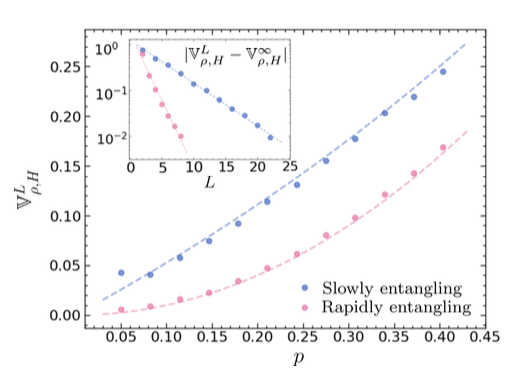

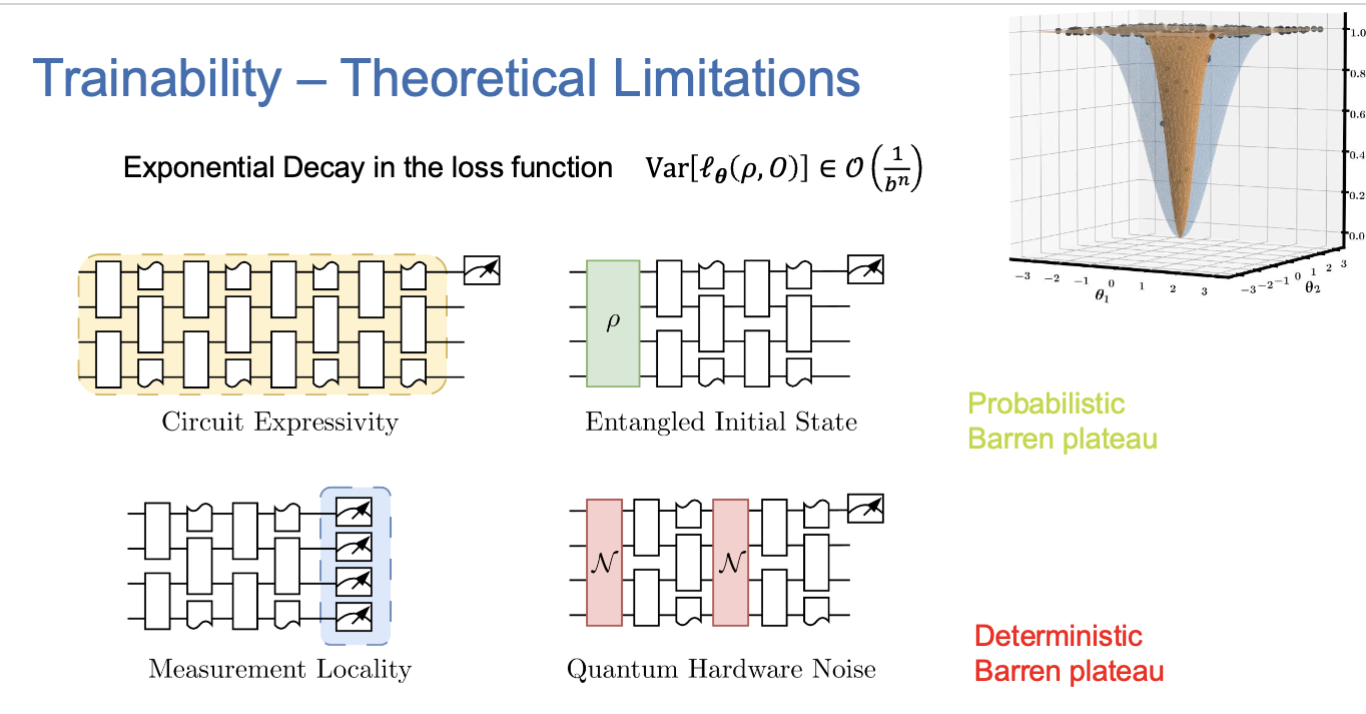

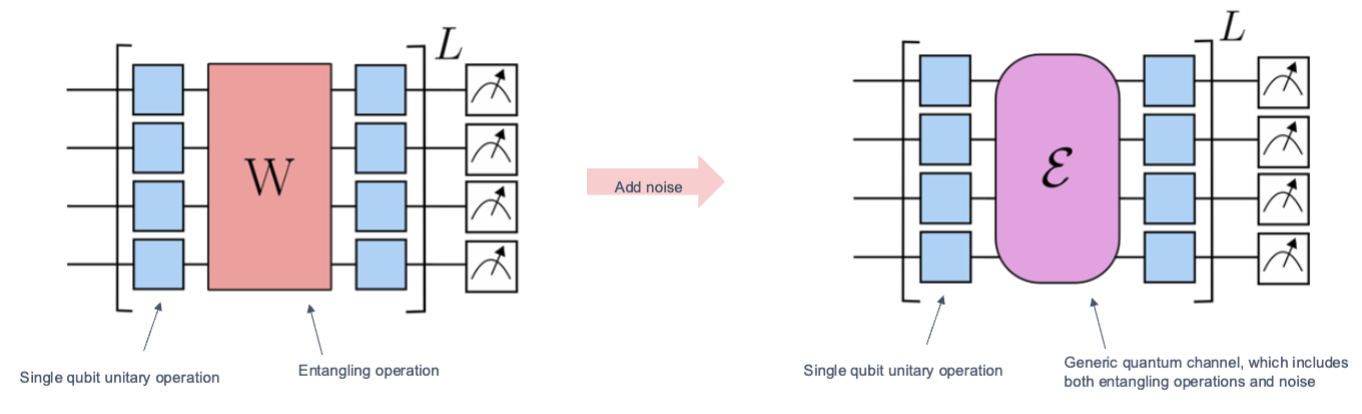

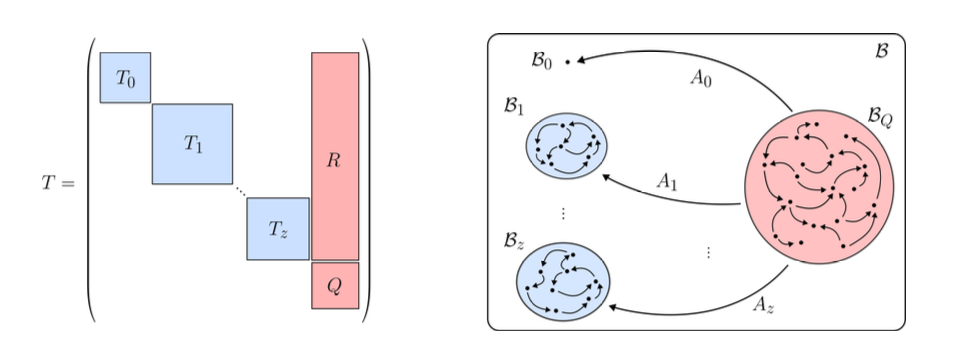

In [ ]:
Qfrom IPython.display import Image, display

# Percorso dell'immagine
image1 = "Img/Screenshot 2025-01-23 alle 11.32.53.png"
image2 = "Img/Screenshot 2025-01-23 alle 11.35.04.png"
image3 = "Img/Screenshot 2025-01-22 alle 11.21.30.png"
image4 = 'Img/Screenshot 2025-01-22 alle 16.47.42.png'

display(Image(filename=image4, width=300, height=200))
display(Image(filename=image1, width=500, height=400))
display(Image(filename=image2, width=500, height=400))
display(Image(filename=image3, width=500, height=400))

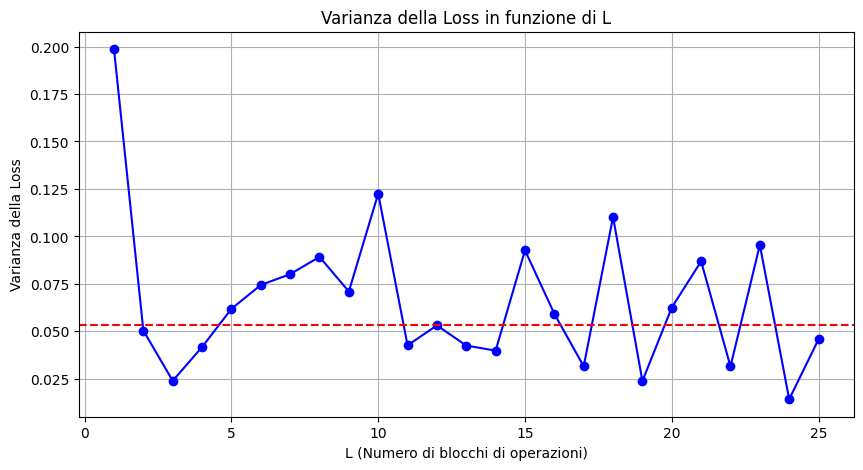

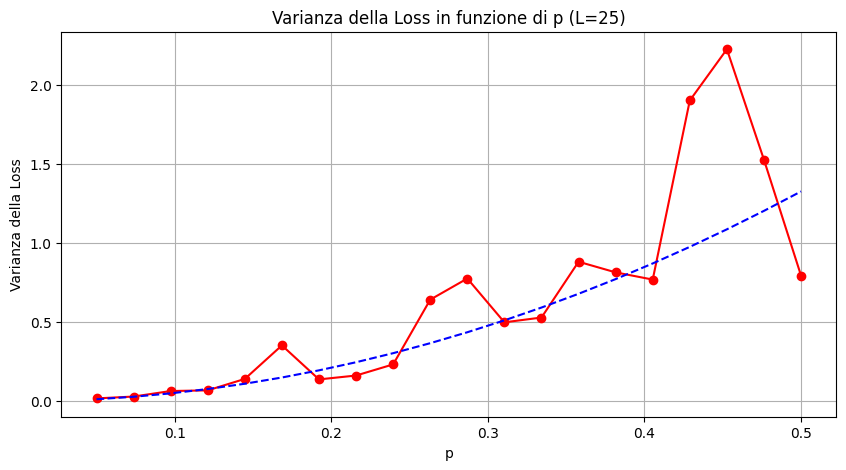

In [6]:
import qiskit as qc
from qiskit_aer import Aer
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, SparsePauliOp
import matplotlib.pyplot as plt
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse.csgraph import connected_components
from functools import reduce

# Parametri
n = 4  # Numero di qubit
shots = 10  # Numero di esecuzioni
L_values_range = 25  # Numero massimo di blocchi di operazioni
p = 0.1  # Probabilità di applicare lo stato GHZ
h = 1  # Coefficiente nell'Hamiltoniano

# Funzione per generare parametri casuali
def generate_random_parameters(n):
    return 2 * np.pi * np.random.rand(2 * n)

# Funzione per mescolare rho con lo stato GHZ
def rho_noise(p, rho):
    rho_ghz = np.zeros_like(rho)
    rho_ghz[0, 0] = 0.5
    rho_ghz[-1, -1] = 0.5
    rho_ghz[0, -1] = 0.5
    rho_ghz[-1, 0] = 0.5
    return p * rho + (1 - p) * rho_ghz

# Funzione per costruire il circuito e applicare il rumore
def circuit_with_noise(n, p, L):

    circuit = QuantumCircuit(n)
    rho = DensityMatrix.from_instruction(circuit).data  # Matrice densità iniziale

    for _ in range(L):
        # Applica rotazioni casuali
        parameters = generate_random_parameters(n)
        for i in range(n):
            circuit.rx(parameters[2 * i], i)
            circuit.rz(parameters[2 * i + 1], i)
        # Applica i CNOT e gli swap
        circuit.cx(0, 1)
        circuit.cx(3, 2)
        circuit.swap(0, 2)
        circuit.swap(1, 3)

        # Evoluzione dello stato
        rho = DensityMatrix.from_instruction(circuit)
        rho = rho_noise(p, rho)
    return rho

# Creazione dell'Hamiltoniano W
pauli_strings = []
coefficients = []

for k in range(n-1):
     # Coefficiente del termine
    coefficients.append(h *(2**(n/2)))
    # Stringa di Pauli per Z_k ⊗ Z_{k+1}
    pauli_string = ['I'] * n
    pauli_string[k] = 'Z'  # Z_k
    pauli_string[(k + 1)] = 'Z'  # Z_{k+1} (periodico)
    pauli_strings.append("".join(pauli_string))

# Creazione dell'Hamiltoniano come SparsePauliOp
W = SparsePauliOp(pauli_strings, coeffs=np.array(coefficients))

# Lista per memorizzare i valori di L
L_values_all = {L: [] for L in range(1, L_values_range + 1)}

# Simulazione per ogni valore di L
for L in range(1, L_values_range + 1):
    L_values_shots = []

    for _ in range(shots):
        rho = circuit_with_noise(n, p, L)  # Stato con rumore
        W_matrix = W.to_matrix()
        L_value = np.trace(W_matrix @ rho.data)  # Loss
        L_values_shots.append(L_value)

    L_values_all[L] = L_values_shots

L_means = {L: np.mean(L_values_all[L]) for L in range(1, L_values_range + 1)}
L_variances = {L: np.var(L_values_all[L]) for L in range(1, L_values_range + 1)}

# Plot della varianza in funzione di L
L_range = list(L_variances.keys())
var_values = list(L_variances.values())
L_values = list(L_means.values())

plt.figure(figsize=(10, 5))
plt.plot(L_range, var_values, marker='o', linestyle='-', color='b')
plt.xlabel('L (Numero di blocchi di operazioni)')
plt.ylabel('Varianza della Loss')
plt.title('Varianza della Loss in funzione di L')
plt.axhline(y=0.0533, color='r', linestyle='--', label="V_inf")
plt.grid(True)
plt.show()

p_values = np.linspace(0.05, 0.5, 20)

for p in p_values:
    L_values_shots = []
    for _ in range(shots):
        rho = circuit_with_noise(n, p, L_values_range)  # Stato con rumore
        W_matrix = W.to_matrix()
        L_value = np.trace(W_matrix @ rho.data)  # Loss
        L_values_shots.append(L_value)
    L_values_all[p] = L_values_shots


L_means = {p: np.mean(L_values_all[p]) for p in p_values}
L_variances = {p: np.var(L_values_all[p]) for p in p_values}
y = 5.3*p_values**2


# Plot della varianza in funzione di p
plt.figure(figsize=(10, 5))
plt.plot(p_values, list(L_variances.values()), marker='o', linestyle='-', color='r')
plt.plot(p_values, y, marker='', linestyle='--', color='b')
plt.xlabel('p')
plt.ylabel('Varianza della Loss')
plt.title(f'Varianza della Loss in funzione di p (L={L_values_range})')
plt.grid(True)
plt.show()

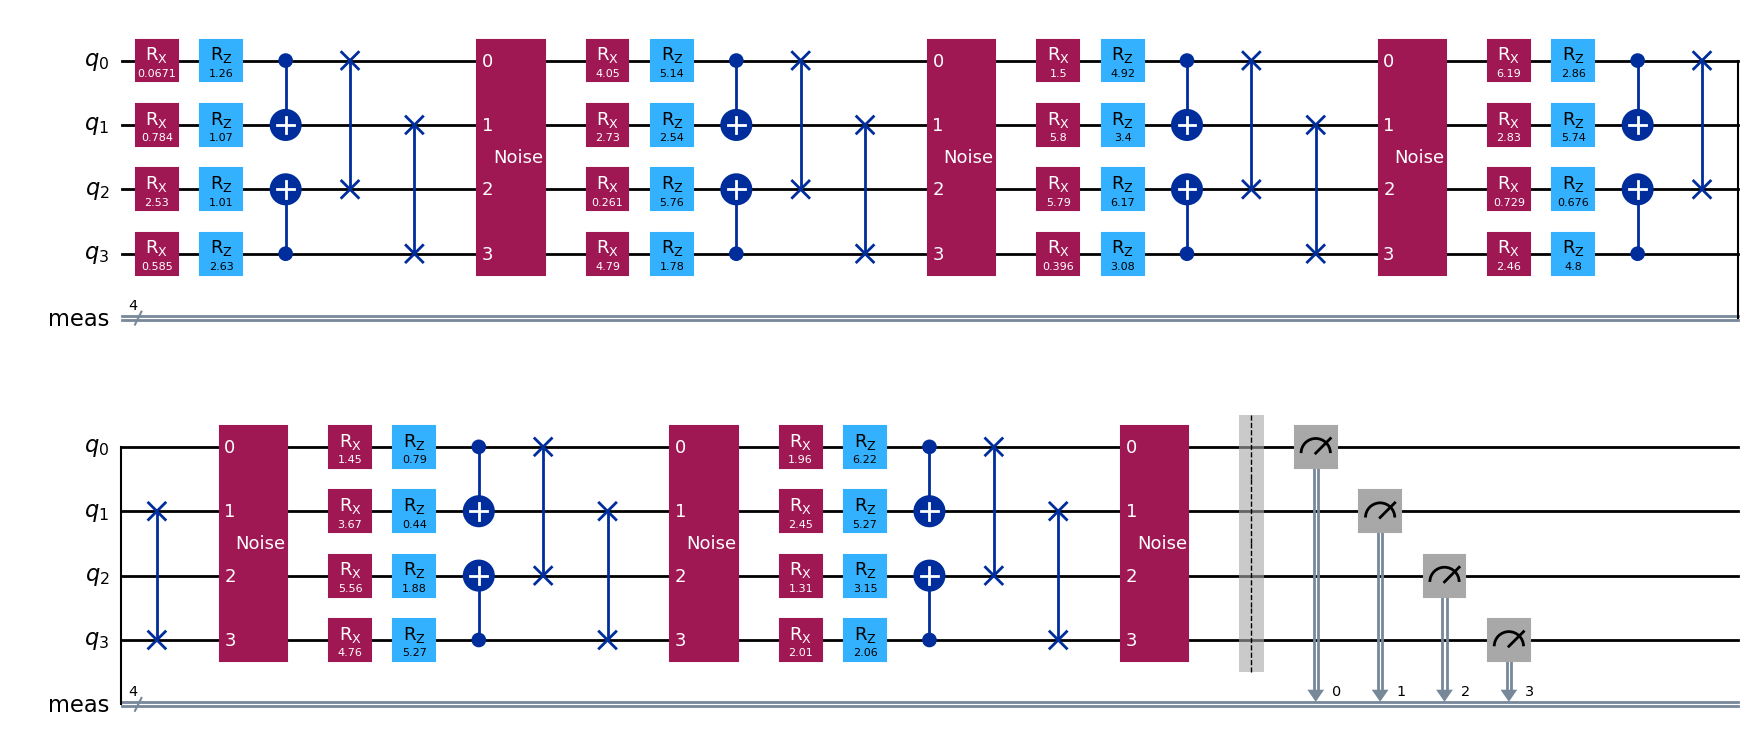

In [7]:
from qiskit.circuit import Gate

L_final=6
noise_gate = Gate(name="Noise", num_qubits=n, params=[])
circuit = QuantumCircuit(n)
rho = DensityMatrix.from_instruction(circuit).data  # Matrice densità iniziale

for _ in range(L_final):
        # Applica rotazioni casuali
    parameters = generate_random_parameters(n)
    for i in range(n):
        circuit.rx(parameters[2 * i], i)
        circuit.rz(parameters[2 * i + 1], i)
        # Applica i CNOT e gli swap
    circuit.cx(0, 1)
    circuit.cx(3, 2)
    circuit.swap(0, 2)
    circuit.swap(1, 3)
    circuit.append(noise_gate, range(n))

circuit.measure_all()

circuit.draw('mpl')

In [9]:
from inspect import trace
import numpy as np
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse.csgraph import connected_components

# 1. Definizione delle matrici di Pauli (normalizzate) e dell'identità
I = np.array([[1, 0], [0, 1]]) / np.sqrt(2)
X = np.array([[0, 1], [1, 0]]) / np.sqrt(2)
Y = np.array([[0, -1j], [1j, 0]]) / np.sqrt(2)
Z = np.array([[1, 0], [0, -1]]) / np.sqrt(2)

pauli_matrices = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
matrix_labels = ['I', 'X', 'Y', 'Z']

n = 4  # Numero di qubit

# 2. Genera tutti i possibili prodotti tensore e definisce la "binary tuple"
tensor_products = []
for combination in itertools.product(matrix_labels, repeat=n):
    tensor = pauli_matrices[combination[0]]
    for label in combination[1:]:
        tensor = np.kron(tensor, pauli_matrices[label])
    binary_tuple = tuple(1 if label != 'I' else 0 for label in combination)
    tensor_products.append((binary_tuple, tensor))

# Ordinamento in base al valore della tuple (facoltativo)
tensor_products.sort(key=lambda item: sum(bit * (2**i) for i, bit in enumerate(item[0])))

# Raggruppa i tensori in base alla binary tuple
groups = defaultdict(list)
for binary_tuple, tensor in tensor_products:
    groups[binary_tuple].append(tensor)

# Lista ordinata delle tuple uniche e definizione del numero J di gruppi
unique_tuples = sorted(groups.keys(), key=lambda tup: sum(bit * (2**i) for i, bit in enumerate(tup)))
J = len(unique_tuples)

# 3. Definizione della matrice H (in questo caso l'identità 4x4)
def random_hermitian_unitary(n):

    # Genera una matrice casuale complessa
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    # Decomposizione QR per ottenere una matrice unitaria Q
    Q, _ = np.linalg.qr(A)
    # Crea una matrice diagonale D con ±1 scelti a caso
    eigenvalues = np.random.choice([-1, 1], size=n)
    D = np.diag(eigenvalues)
    # Costruisci la trasformazione U = Q D Q†
    U = Q @ D @ Q.conj().T
    return U



# 4. Costruzione della matrice T:
# Per ciascun gruppo j (per tensori B) e per ciascun gruppo k (per tensori P)
# si somma (con normalizzazione) il contributo: (trace(H† B H P))^2.
T = np.zeros((J, J), dtype=complex)

LC_vec = np.zeros(len(unique_tuples))

def compute_LC_vec(AV):
    LC_vec = np.zeros(len(unique_tuples))
    for k_idx, tup_k in enumerate(unique_tuples):
        trace_sum = 0
        norm_factor_P = 3 ** (sum(tup_k))
        for P in groups[tup_k]:
            trace_val = np.trace(AV @ P)
            trace_sum += (trace_val**2) / np.sqrt(norm_factor_P)
        LC_vec[k_idx] += trace_sum
    return LC_vec


def generate_GHZ_matrix(n):
    dim = 2**n
    GHZ = np.zeros((dim, dim))
    GHZ[0, 0] = 0.5
    GHZ[-1, -1] = 0.5
    GHZ[0, -1] = 0.5
    GHZ[-1, 0] = 0.5
    return GHZ

def modify_matrix(A, p):
    """Modifica la matrice A moltiplicandola per (1-p) e aggiungendo uno stato GHZ moltiplicato per p."""
    n = int(np.log2(A.shape[0]))  # Assumiamo che A sia una matrice quadrata 2^n x 2^n
    ghz = generate_GHZ_matrix(n)

    # Moltiplica A per (1 - p)
    modified_A = A * (1 - p)

    # Aggiungi la matrice GHZ moltiplicata per p
    modified_A += p * (ghz @ ghz.T)  # ghz @ ghz.T crea la matrice densità GHZ

    return modified_A



H= W.to_matrix()
traccia = np.trace(H)

# Funzione per creare la matrice di rotazione RY per un angolo theta
def RY(theta):
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2),  np.cos(theta / 2)]], dtype=complex)

# Definizione del gate CNOT per 2 qubit
def CNOT(control, target):
    CNOT_matrix = np.eye(4, dtype=complex)
    CNOT_matrix[2:4, 2:4] = np.array([[0, 1], [1, 0]])  # CNOT operation
    return CNOT_matrix

# Angolo di rotazione
theta = np.pi / 4  # Sostituisci con l'angolo desiderato

# Creazione della matrice di rotazione per ogni qubit
RY1 = RY(theta)  # Rotazione per il primo qubit
RY2 = RY(theta)  # Rotazione per il secondo qubit
RY3 = RY(theta)  # Rotazione per il terzo qubit
RY4 = RY(theta)  # Rotazione per il quarto qubit

# Creazione delle matrici CNOT per i qubit
CNOT_1_2 = np.kron(CNOT(0, 1), np.eye(4))  # CNOT tra qubit 1 e 2
CNOT_3_4 = np.kron(np.eye(4), CNOT(2, 3))  # CNOT tra qubit 3 e 4

# Composizione finale della matrice H
H = CNOT_3_4 @ CNOT_1_2 @ np.kron(RY1, np.kron(RY2, np.kron(RY3, RY4)))

# 4. Costruzione della matrice T:
# Per ciascun gruppo j (per tensori B) e per ciascun gruppo k (per tensori P)
# si somma (con normalizzazione) il contributo: (trace(H† B H P))^2.
T = np.zeros((J, J), dtype=complex)

for j_idx, tup_j in enumerate(unique_tuples):
    LT_vec = np.zeros(J, dtype=complex)
    # Calcola il fattore di normalizzazione per il gruppo B: per ogni '1' nella tuple si ha un fattore 3
    norm_factor_B = 3 ** (sum(tup_j))

    # Per ogni tensore B nel gruppo j
    for B in groups[tup_j]:
        # Ciclo sui gruppi per P (indice k)
        for k_idx, tup_k in enumerate(unique_tuples):
            trace_sum = 0
            # Fattore di normalizzazione per il gruppo P
            norm_factor_P = 3 ** (sum(tup_k))
            for P in groups[tup_k]:
                trace_val = np.trace(H.conj().T @ B @ H @ P)
                # Normalizzazione: il contributo viene diviso per il prodotto dei fattori per B e per P
                trace_sum += (trace_val**2) / (norm_factor_B )
            LT_vec[k_idx] += trace_sum
    T[j_idx, :] = LT_vec


GHZ = generate_GHZ_matrix(n)
HM=generate_tensor_product_matrix(n,1)

l1=compute_LC_vec(GHZ)
l2=compute_LC_vec(H)
a, total_normalized_sum = plot_LC_product(l1, l2)


# 5. Diagonalizzazione a blocchi fortemente connessi tramite permutazioni
# Costruiamo una "matrice di connettività": consideriamo un arco tra i nodi i e j se |T[i,j]| > tol
tol = 1e-16
connectivity = (np.abs(T) > tol).astype(int)

# Trova i componenti connessi (trattando la matrice come grafo non diretto)
n_components, comp_labels = connected_components(connectivity, directed=False, connection='weak')

# La permutazione che raggruppa per componente è data da:
permutation = np.argsort(comp_labels)
# Riordiniamo T per ottenere una forma bloc-diagonale
T_perm = T[permutation, :][:, permutation]

# Salviamo la mappatura della permutazione: (nuovo indice -> indice originale)
perm_mapping = {new_idx: old_idx for new_idx, old_idx in enumerate(permutation)}

# 6. Plot della matrice T permutata come heatmap (si plottano i valori reali)
plt.figure(figsize=(8, 6))
plt.imshow(np.real(T_perm), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel("Indice permutato per P (tupla unica)")
plt.ylabel("Indice permutato per B (tupla unica)")
plt.title("Heatmap della matrice T (blocchi fortemente connessi)")
plt.show()



# Salva (o stampa) la mappatura della permutazione
print("Mappatura della permutazione (nuovo indice -> indice originale):")
print(perm_mapping)


NameError: name 'generate_tensor_product_matrix' is not defined

In [10]:

def plot_LC_product(l1, l2):
    # Calcola il prodotto dei vettori
    a = l1 * l2
    np.save('LC_product.npy', a)

    # Inizializza una lista per i contributi normalizzati
    normalized_contributions = []

    # Ciclo attraverso le componenti del vettore e gli indici delle tuple
    for i, tup_j in enumerate(unique_tuples):
        normalized_value = a[i]
        normalized_contributions.append(normalized_value)

    # Crea un istogramma con barre numerate
    indices = np.arange(len(a))
    plt.bar(indices, a, alpha=0.7, color='blue')

    # Aggiungi le etichette sopra le barre
    for i, value in enumerate(a):
        plt.text(i, value, str(value), ha='center', va='bottom')

    plt.xlabel('Index')
    plt.ylabel('Product Value')
    plt.title('Bar Chart of Component-wise Product of LC_vec')
    plt.grid(True)
    plt.show()

    # Calcola la somma totale dei contributi normalizzati
    total_normalized_sum = np.sum(normalized_contributions)

    return a, total_normalized_sum

V =  0.01 * total_normalized_sum
print("Varianza infinito=", V)
print("Varianza infinito in funzione di p= p^2*", total_normalized_sum)


NameError: name 'total_normalized_sum' is not defined